#W207.5 Group Project

##Nate Black, Vineet Gangwar, Jared Maslin, Malini Mittal

##Kaggle Competition - "Forest Cover Type Prediction"

##MIDS Summer 2015 Term

###Section 1: Description of Kaggle Competition (with background and goal)

####Competition Description: Summary and Objective

This competition seeks to predict the forest cover type from strictly cartographic variables. The actual forest cover type for a given 30m x 30m patch was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were then derived from data obtained from the US Geological Survey and USFS. The data is in raw form (not scaled) and contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.

The dataset was provided by Jock A. Blackard and Colorado State University, and is hosted by UCI machine learning repository.

The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. The goal is to predict an integer classification for the forest cover type. 

The seven types are:
    Spruce/Fir, 
    Lodgepole Pine, 
    Ponderosa Pine, 
    Cottonwood/Willow, 
    Aspen, 
    Douglas-fir, 
    Krummholz

The training set (15120 observations) contains both features and the Cover_Type. 

The test set contains only the features.

    Data Fields:
    Elevation - Elevation (in meters)
    Aspect - Aspect (in degrees azimuth)
    Slope - Slope (in degrees)
    Horizontal_Distance_To_Hydrology - Horizontal distance to nearest surface water features
    Vertical_Distance_To_Hydrology - Vertical distance to nearest surface water features
    Horizontal_Distance_To_Roadways - Horizontal distance to nearest roadway
    Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
    Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
    Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
    Horizontal_Distance_To_Fire_Points - Horizontal distance to nearest wildfire ignition points
    Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
    Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
    Cover_Type (7 types, integers 1 to 7) - Forest Cover Type Label

###Section 2: Data Loading and Exploration

Let's load some libraries that will allow us to explore the data...

In [116]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import csv
from itertools import combinations
from scipy.sparse import csr_matrix, hstack
from math import sqrt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from scipy.stats import randint as sp_randint
from sklearn.grid_search import RandomizedSearchCV
from sklearn.mixture import GMM
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [117]:
train_data = pd.read_csv('train.csv')
train_labels = train_data['Cover_Type'].values
train_id = train_data['Id'].values

test_data = pd.read_csv('test.csv') 
test_id = test_data['Id'].values

#Map tree codes to names
tree_map = {1:'Spruce/Fir',
            2:'Lodgepole Pine',
            3:'Ponderosa Pine',
            4:'Cottonwood/Willow',
            5:'Aspen',
            6:'Douglas-fir',
            7:'Krummholz'}

train_data['Tree'] = train_data['Cover_Type'].apply(func = lambda x: tree_map[x])

In [118]:
gb = train_data.groupby(['Tree'])
gb['Id'].count()

Tree
Aspen                2160
Cottonwood/Willow    2160
Douglas-fir          2160
Krummholz            2160
Lodgepole Pine       2160
Ponderosa Pine       2160
Spruce/Fir           2160
Name: Id, dtype: int64

In [119]:
print train_data.describe()

                Id     Elevation        Aspect         Slope  \
count  15120.00000  15120.000000  15120.000000  15120.000000   
mean    7560.50000   2749.322553    156.676653     16.501587   
std     4364.91237    417.678187    110.085801      8.453927   
min        1.00000   1863.000000      0.000000      0.000000   
25%     3780.75000   2376.000000     65.000000     10.000000   
50%     7560.50000   2752.000000    126.000000     15.000000   
75%    11340.25000   3104.000000    261.000000     22.000000   
max    15120.00000   3849.000000    360.000000     52.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      15120.000000                    15120.000000   
mean                         227.195701                       51.076521   
std                          210.075296                       61.239406   
min                            0.000000                     -146.000000   
25%                           67.000000         

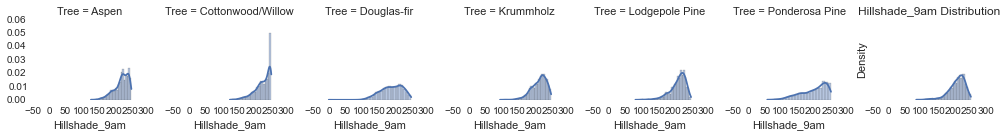

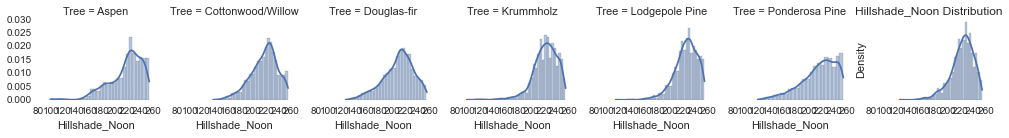

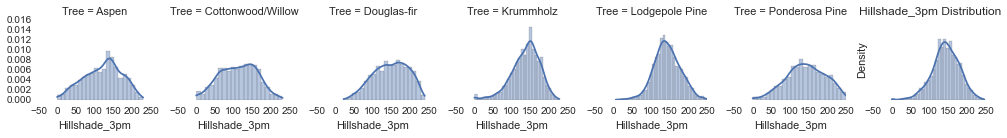

In [120]:
ordinal_columns = [
    'Hillshade_9am', 
    'Hillshade_Noon', 
    'Hillshade_3pm'
]

def ord_dist(var):
    items = sns.FacetGrid(train_data, col = 'Tree', size= 2)
    #dist_plot = (hist=False, rug=True, color ='r')
    items.map(sns.distplot, var)
    plt.title(var + " Distribution")
    plt.xlabel('')
    plt.ylabel('Density')
    plt.show();
    
for col in ordinal_columns:
    ord_dist(col)

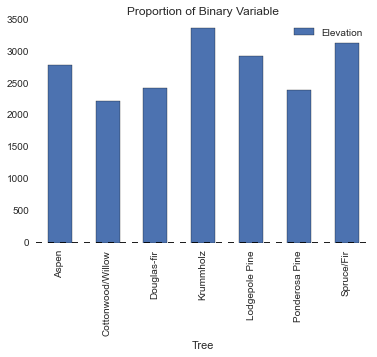

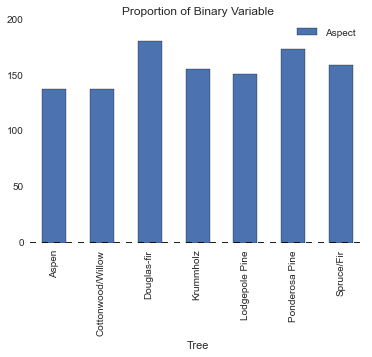

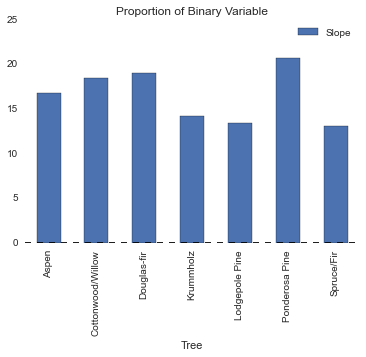

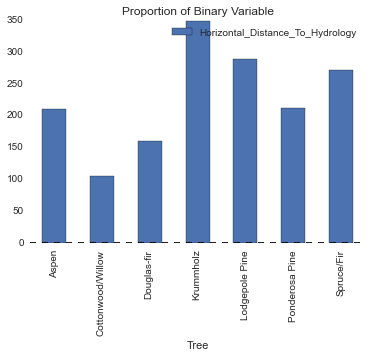

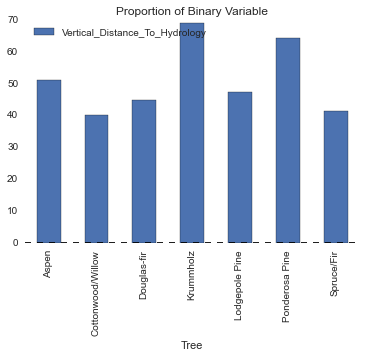

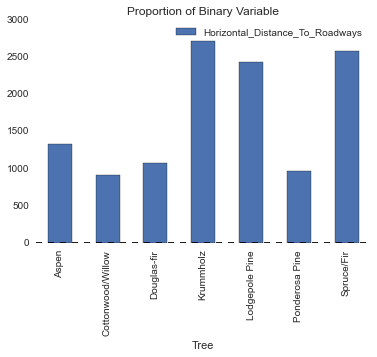

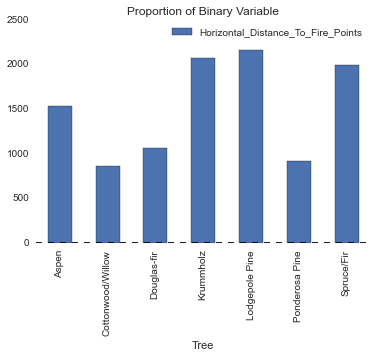

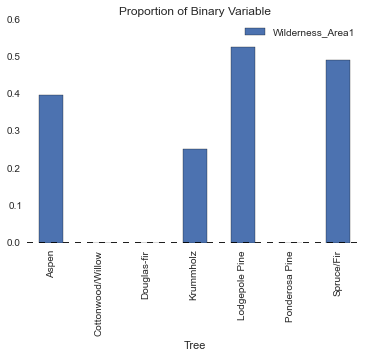

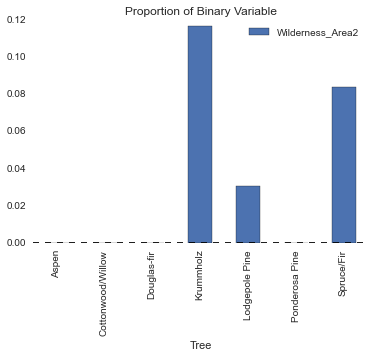

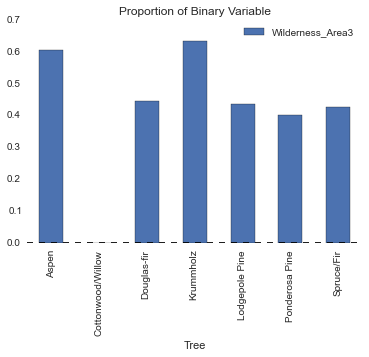

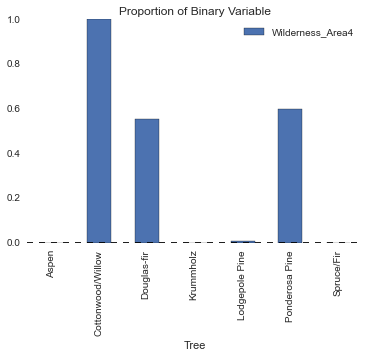

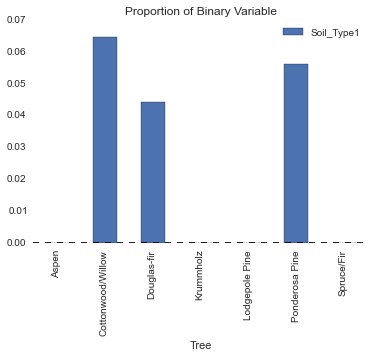

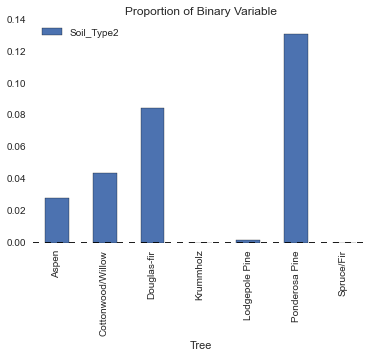

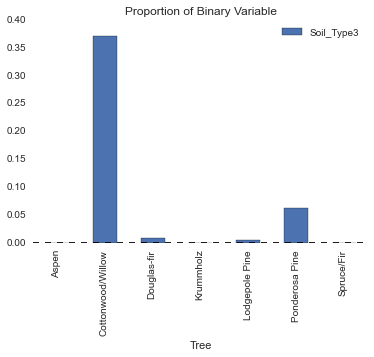

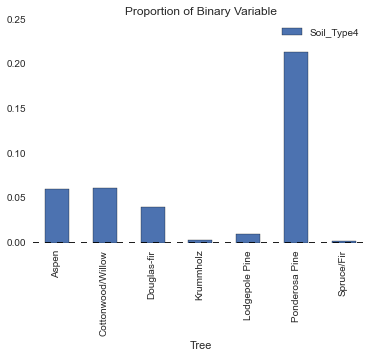

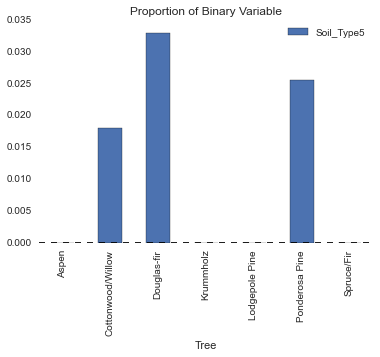

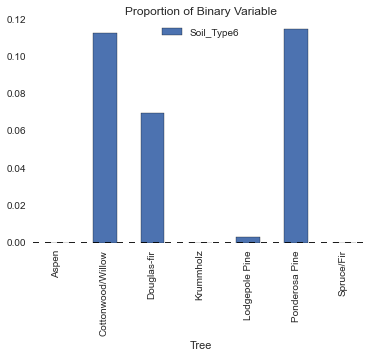

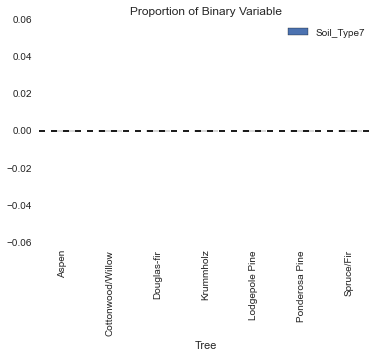

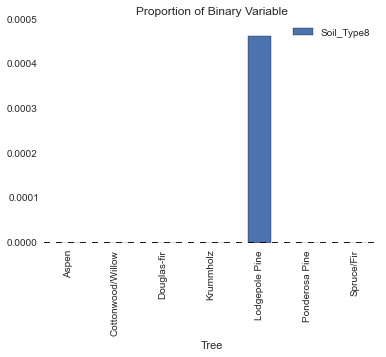

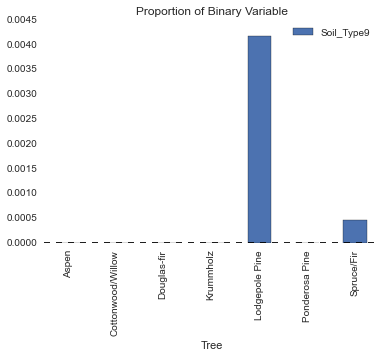

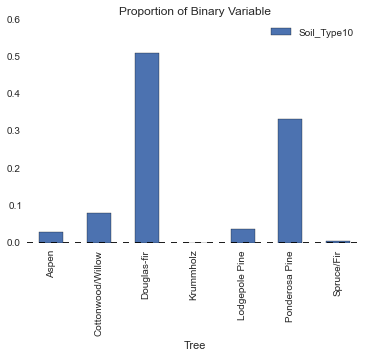

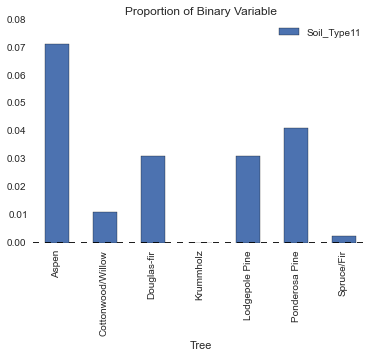

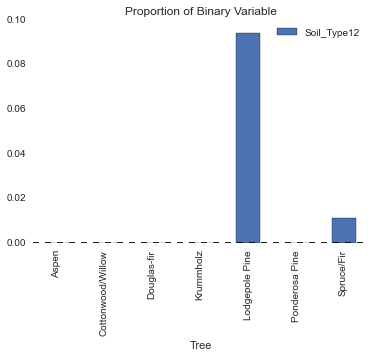

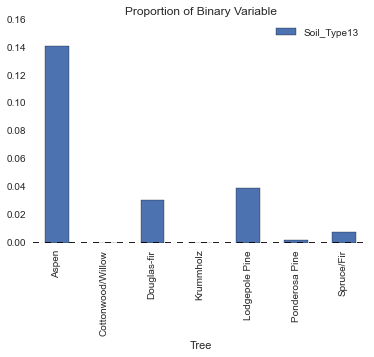

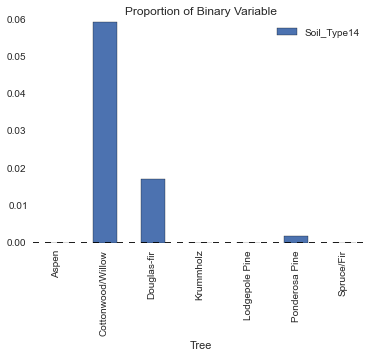

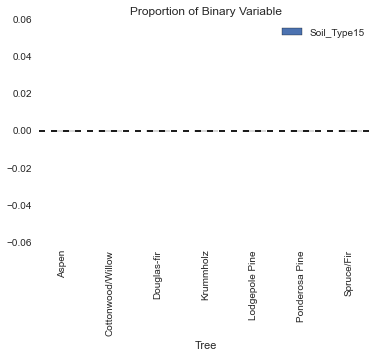

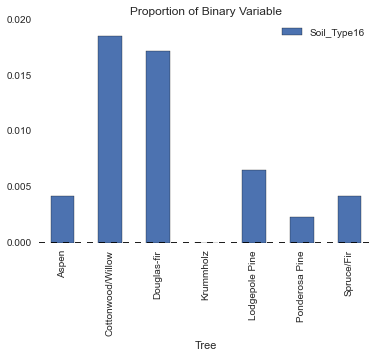

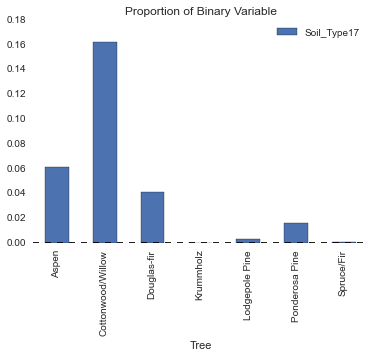

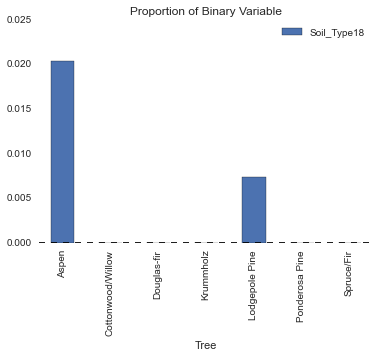

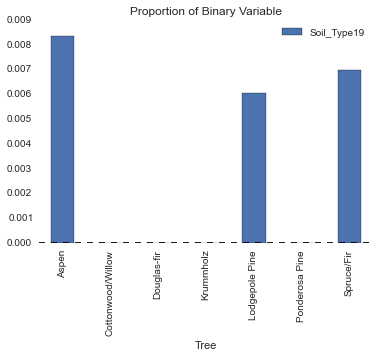

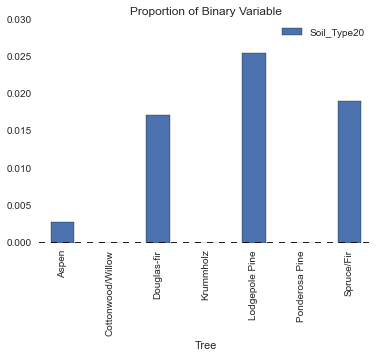

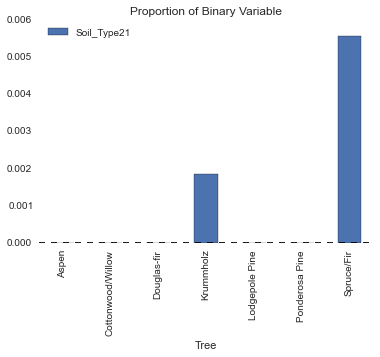

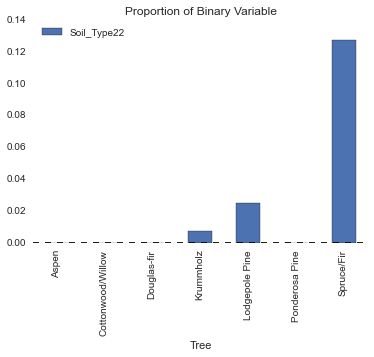

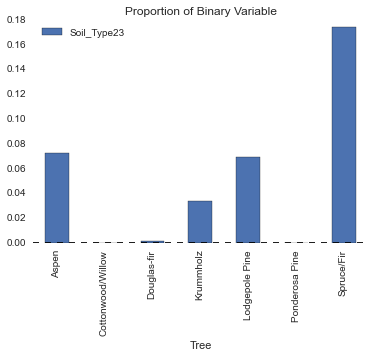

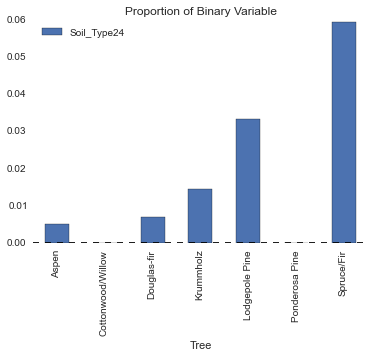

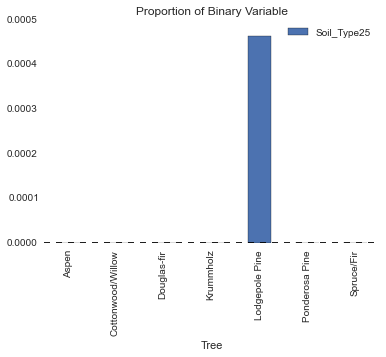

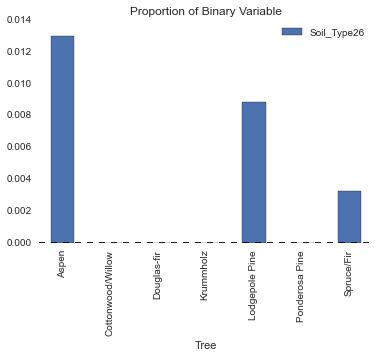

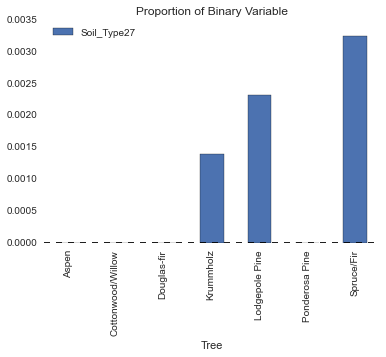

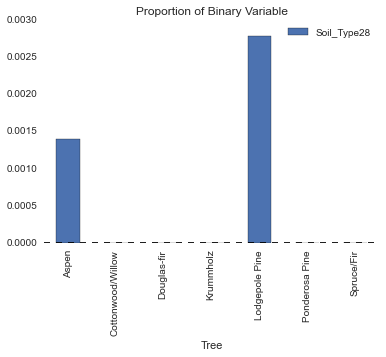

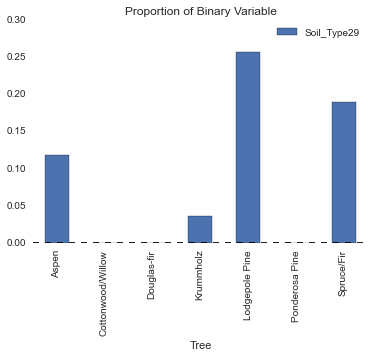

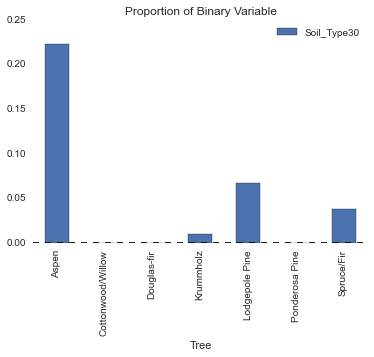

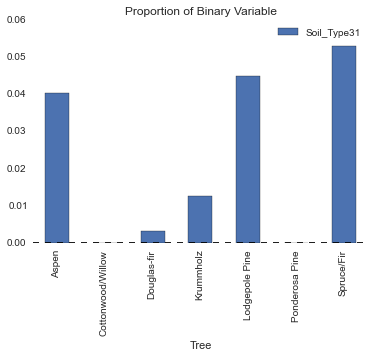

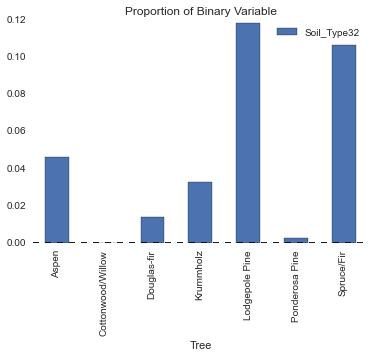

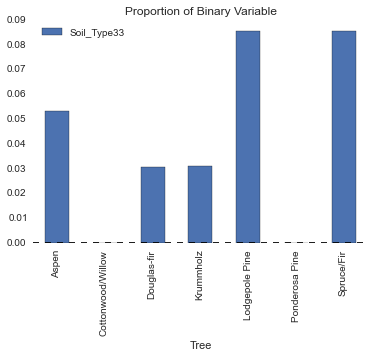

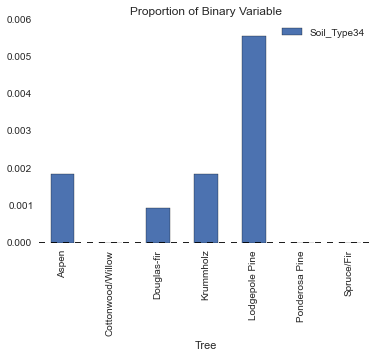

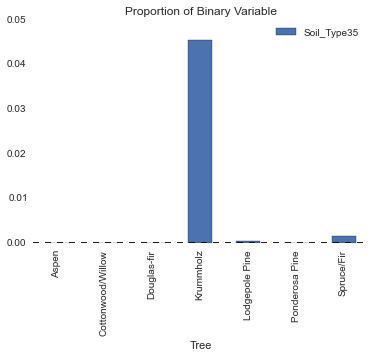

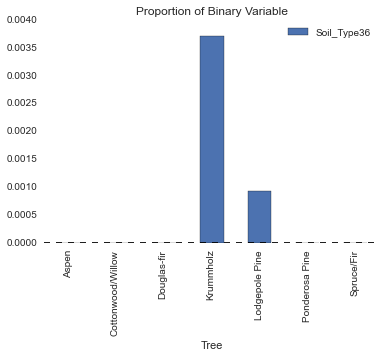

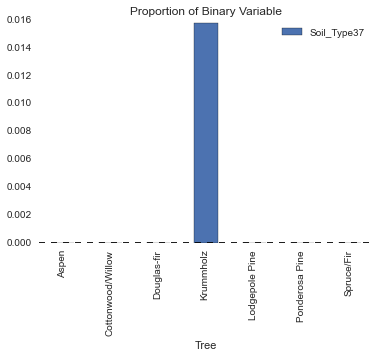

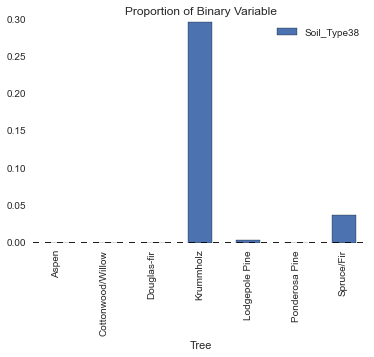

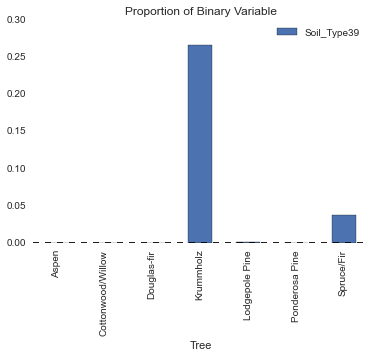

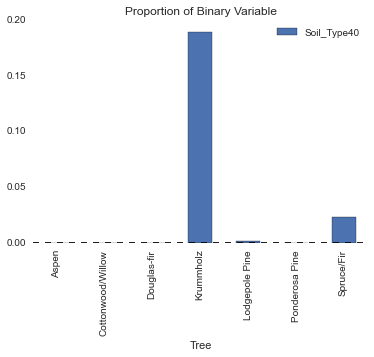

In [121]:
nonbin = ordinal_columns + ['Tree', 'Id', 'Cover_Type']
binary_columns = [x for x in train_data.columns if x not in nonbin]

def binary_dist(var):
    gb = train_data.groupby(['Tree'])[var].mean()
    df = pd.DataFrame(gb)
    df.plot(kind='bar', title = "Proportion of Binary Variable")

for i in binary_columns:
    binary_dist(i)

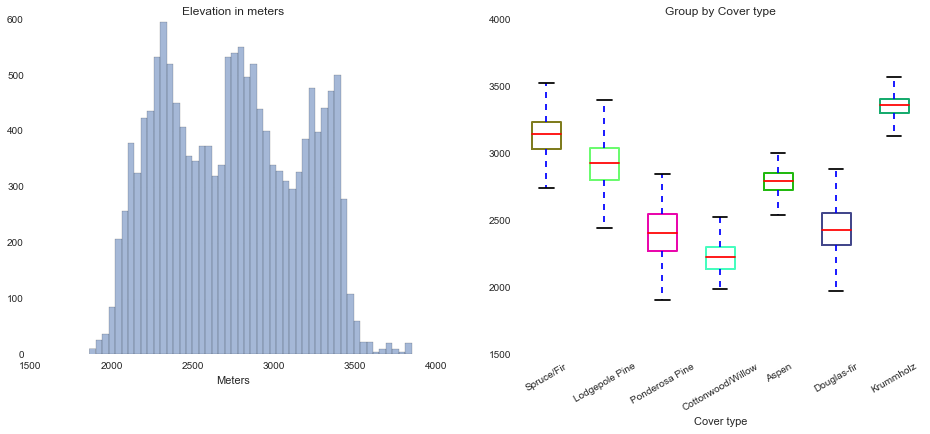

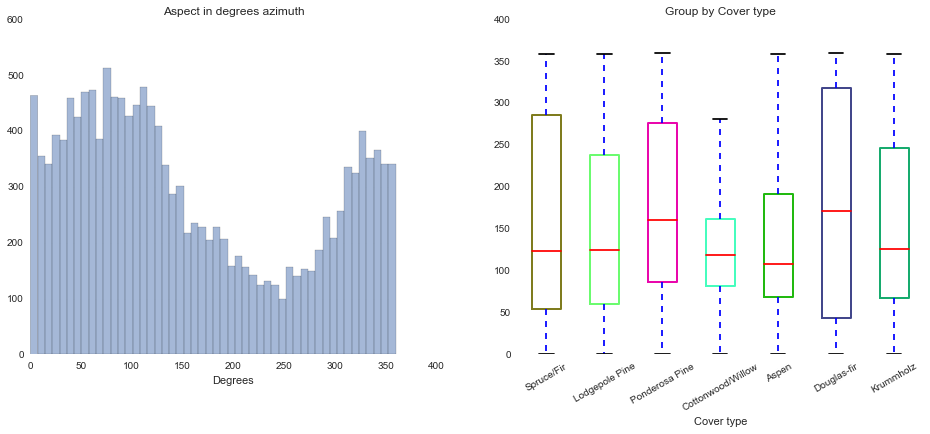

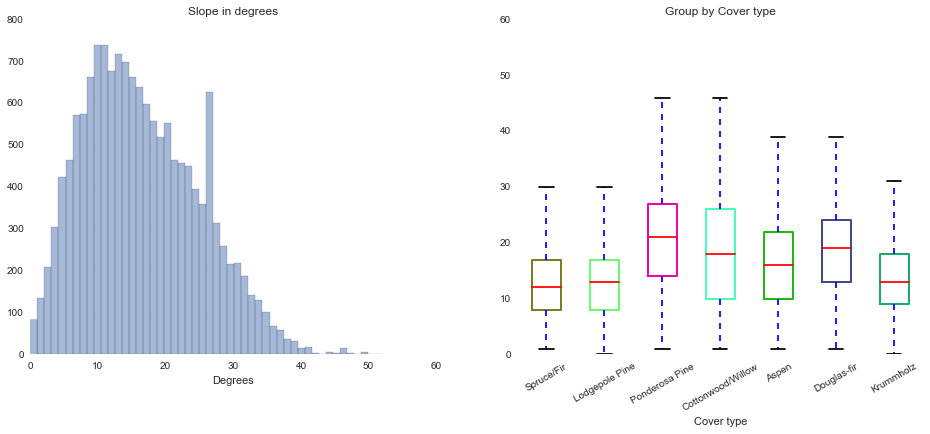

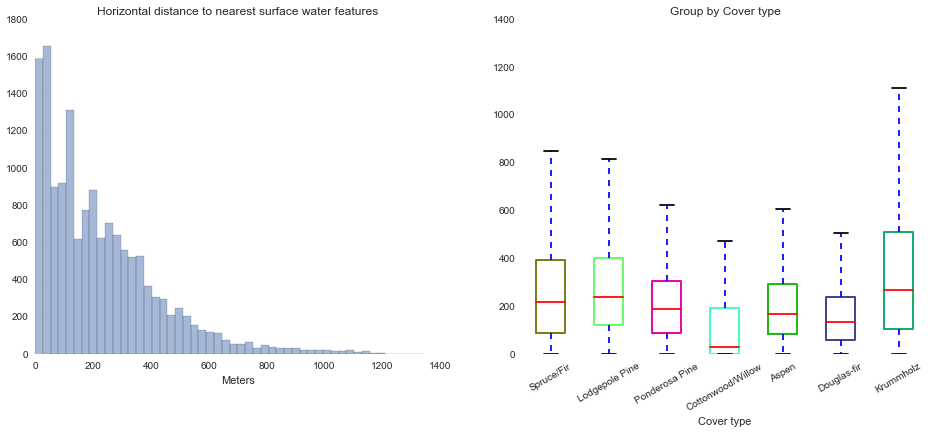

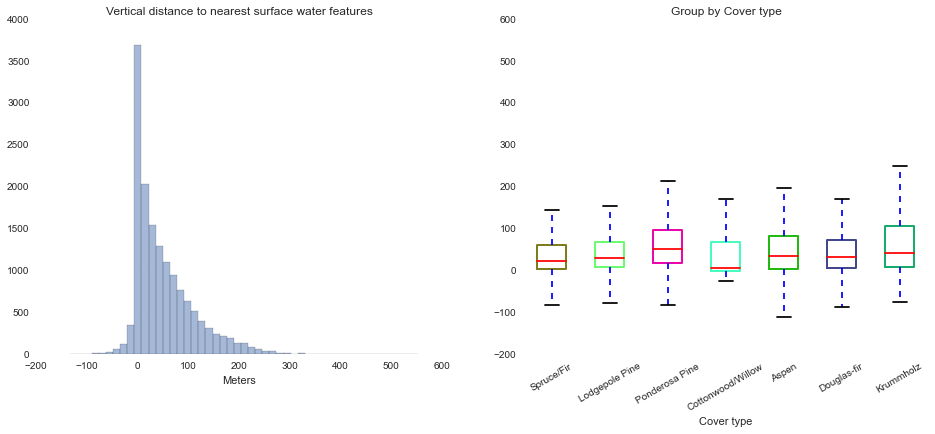

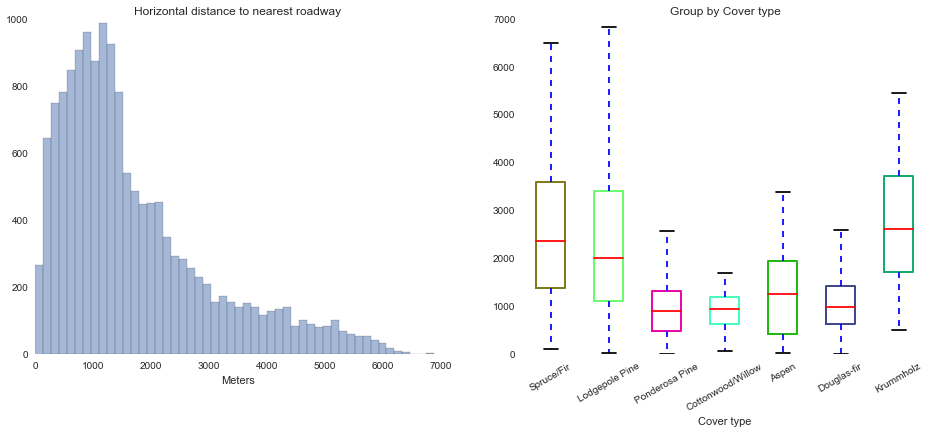

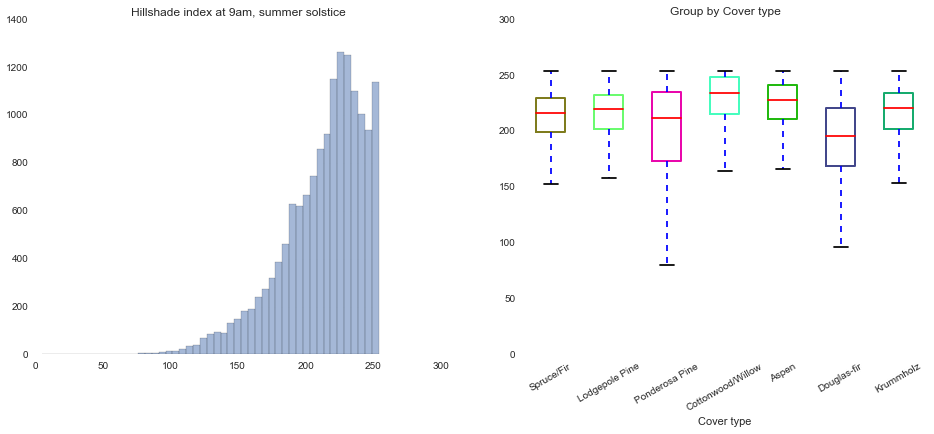

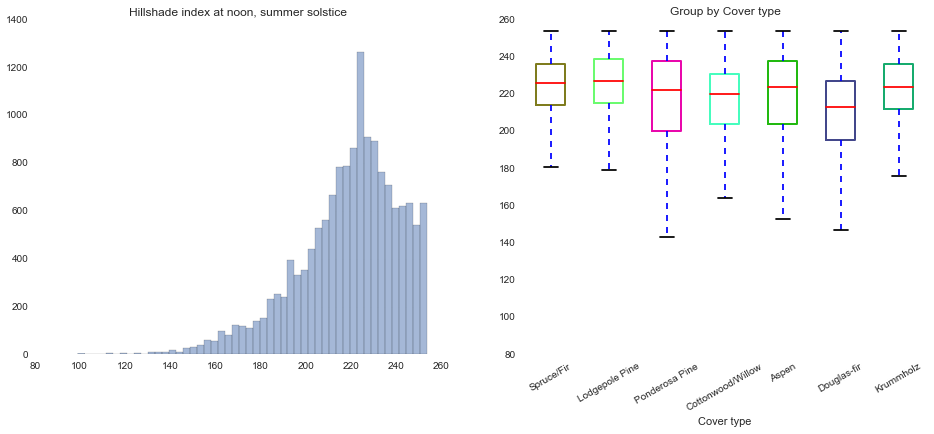

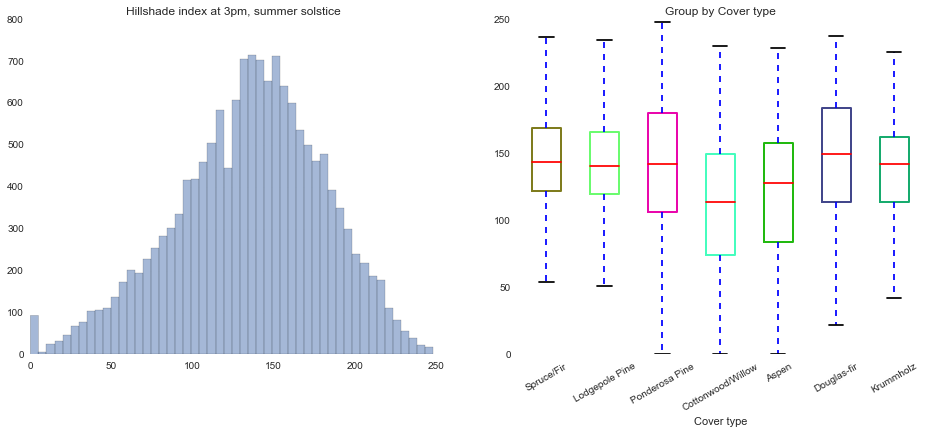

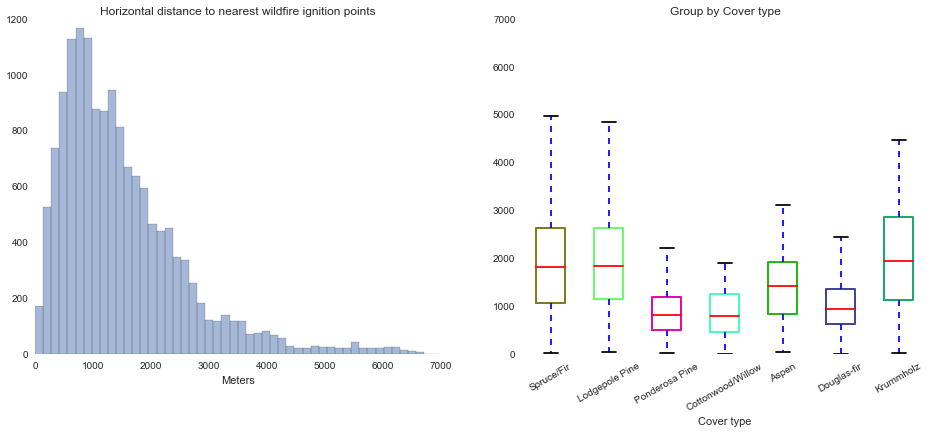

In [122]:
# Visualizing data distributions - Plotting histograms

cover_type = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
random_colors = np.random.rand(7, 3)

def plot_histogram(ax, data, title, xlab):
    ax.hist(data, bins=50, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel(xlab)

# Aspect and Cover type
def plot_class_wise_data(ax, data, labels):
    boxplotdata = list()
    for classes in range(1, 8):
        sub_data = data[np.where(labels == classes)]
        boxplotdata.append(sub_data)

    bp = ax.boxplot(boxplotdata)
    ax.set_xlabel('Cover type')
    ax.set_title('Group by Cover type')
    ax.set_xticklabels(cover_type, rotation=30)

    for i, box in enumerate(bp['boxes']):
        box.set(color=random_colors[i,:], linewidth=2)

def plotter(data, labels, title_1, x_label_1):
    fig = plt.figure(figsize=(16, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    plot_histogram(ax1, data, title_1, x_label_1)
    ax2 = fig.add_subplot(1, 2, 2)
    plot_class_wise_data(ax2, data, labels)

# Elevation
title_1 = 'Elevation in meters'
x_label_1 = 'Meters'
data = train_data.Elevation.values
plotter(data, train_labels, title_1, x_label_1)

# Aspect
title_1 = 'Aspect in degrees azimuth'
x_label_1 = 'Degrees'
data = train_data.Aspect.values
plotter(data, train_labels, title_1, x_label_1)

# Slope in degrees
title_1 = 'Slope in degrees'
x_label_1 = 'Degrees'
data = train_data.Slope.values
plotter(data, train_labels, title_1, x_label_1)

# Horizontal_Distance_To_Hydrology
title_1 = 'Horizontal distance to nearest surface water features'
x_label_1 = 'Meters'
data = train_data.Horizontal_Distance_To_Hydrology.values
plotter(data, train_labels, title_1, x_label_1)

# Vertical_Distance_To_Hydrology
title_1 = 'Vertical distance to nearest surface water features'
x_label_1 = 'Meters'
data = train_data.Vertical_Distance_To_Hydrology.values 
plotter(data, train_labels, title_1, x_label_1)

# Horizontal_Distance_To_Roadways
title_1 = 'Horizontal distance to nearest roadway'
x_label_1 = 'Meters'
data = train_data.Horizontal_Distance_To_Roadways.values
plotter(data, train_labels, title_1, x_label_1)

# Hillshade_9am
title_1 = 'Hillshade index at 9am, summer solstice'
x_label_1 = ''
data = train_data.Hillshade_9am.values
plotter(data, train_labels, title_1, x_label_1)

# Hillshade_Noon
title_1 = 'Hillshade index at noon, summer solstice'
x_label_1 = ''
data = train_data.Hillshade_Noon.values
plotter(data, train_labels, title_1, x_label_1)

# Hillshade_3pm
title_1 = 'Hillshade index at 3pm, summer solstice'
x_label_1 = ''
data = train_data.Hillshade_3pm.values
plotter(data, train_labels, title_1, x_label_1)

# Horizontal_Distance_To_Fire_Points
title_1 = 'Horizontal distance to nearest wildfire ignition points'
x_label_1 = 'Meters'
data = train_data.Horizontal_Distance_To_Fire_Points.values
plotter(data, train_labels, title_1, x_label_1)

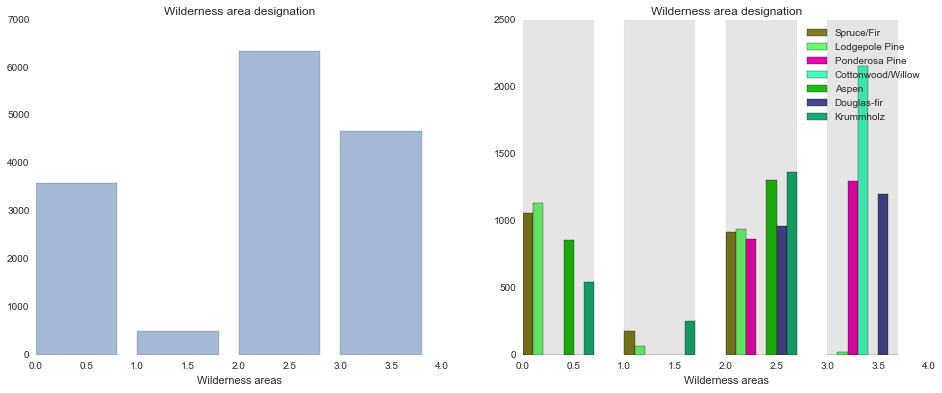

In [123]:
wilderness_area_names = ['Rawah', 'Neota', 'Comanche Peak', 'Cache la Poudre']

fig = plt.figure(figsize=(16, 6))

train_wilderness = train_data[['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']]
train_wilderness_arr = train_wilderness.values

# Wilderness_Area
wilderness_areas = np.sum(train_wilderness_arr, axis=0)
ax = fig.add_subplot(1, 2, 1)
dummy = ax.bar(np.arange(4), wilderness_areas, alpha=0.5)
dummy = ax.set_title("Wilderness area designation")
dummy = ax.set_xlabel('Wilderness areas')

# Wilderness_Area per cover type
ax = fig.add_subplot(1, 2, 2)

ind = np.arange(4)
width = 0.1

for i in range(1, 8):
    wilderness_areas = np.sum(train_wilderness_arr[np.where(train_labels==i)], axis=0)
    bar = ax.bar(ind, wilderness_areas, width=width, color=random_colors[i-1,:])
    ind = ind + width
    dummy = ax.set_title("Wilderness area designation")
    dummy = ax.set_xlabel('Wilderness areas')
    ax.legend(cover_type)
dummy = ax.set_xlim(0, 4)
bar = ax.bar(np.arange(4), [2500, 2500, 2500, 2500], width=(width*7), color='black', alpha=0.1)

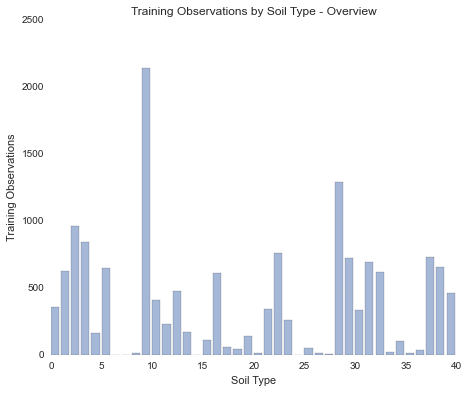

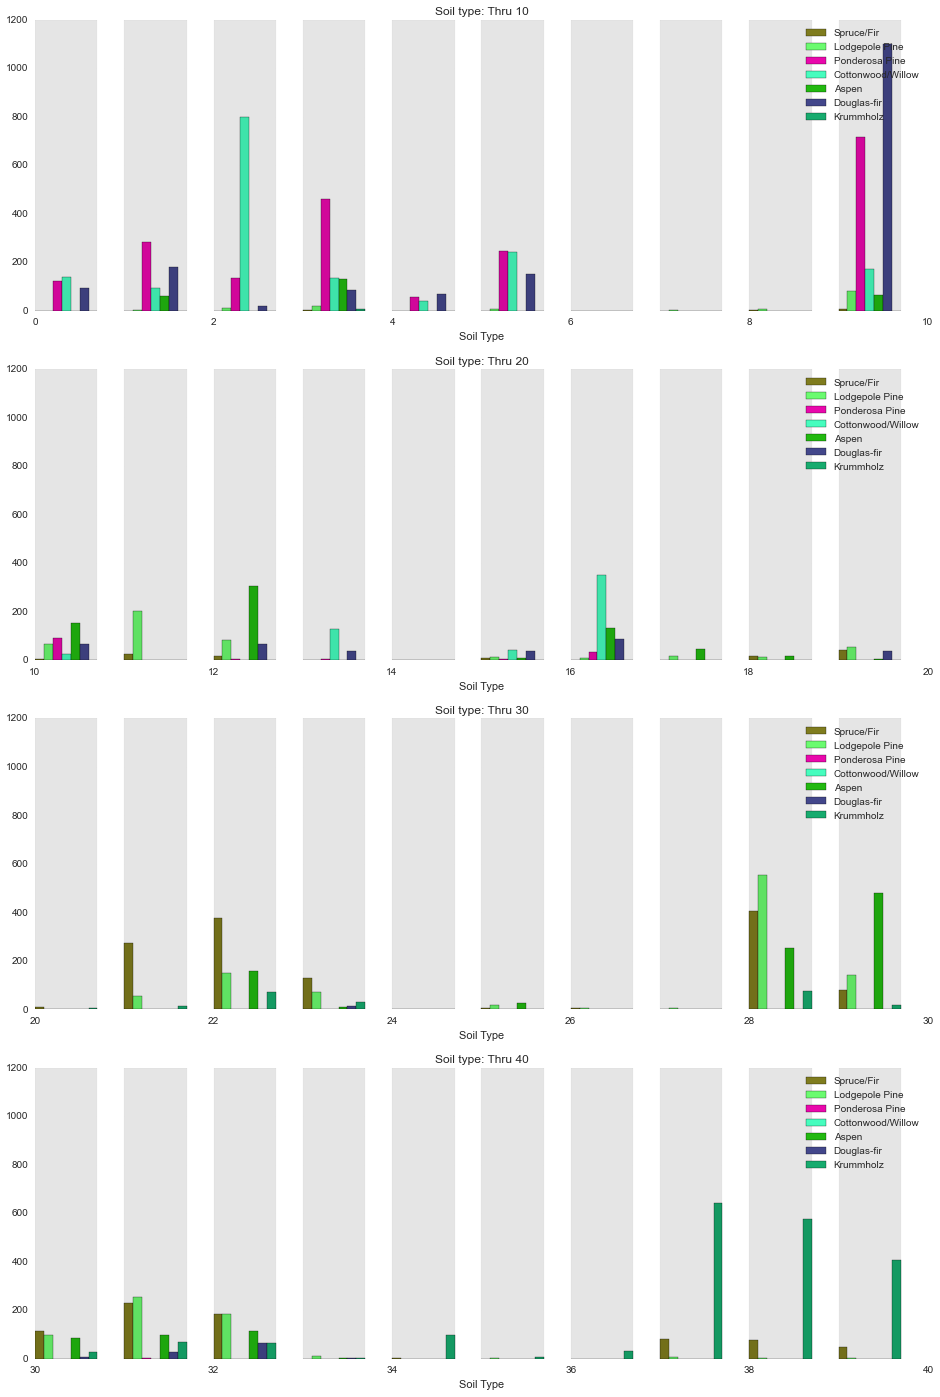

In [124]:
# Soil_Type
fig = plt.figure(figsize=(16, 6))
soil_type = np.sum(train_data_arr[:,15:55], axis=0)
ax = fig.add_subplot(1, 2, 1)
dummy = ax.bar(np.arange(40), soil_type, alpha=0.5)
dummy = ax.set_title("Training Observations by Soil Type - Overview")
dummy = ax.set_xlabel('Soil Type')
dummy = ax.set_ylabel('Training Observations')

# Soil type per cover type
fig = plt.figure(figsize=(16, 24))

for j in range(4):
    ax = fig.add_subplot(4, 1, j+1)
    dummy = ax.set_title("Training Observations by Soil Type - Detailed")
    ind = np.arange(10*j, 10*j+10)
    width = 0.1
    for i in range(1, 8):
        soil_type = np.sum(train_data_arr[np.where(train_labels==i),((j+1)*10)+5:((j+1)*10)+15][0], axis=0)
        bar = ax.bar(ind, soil_type, width=width, color=random_colors[i-1,:])
        ind = ind + width
        title = "Soil type: Thru " + str((j+1) * 10)
        dummy = ax.set_title(title)
        dummy = ax.set_xlabel('Soil Type')
        ax.legend(cover_type)
    bar = ax.bar(np.arange(10*j, 10*j+10), [1200]*10, width=(width*7), color='black', alpha=0.1)

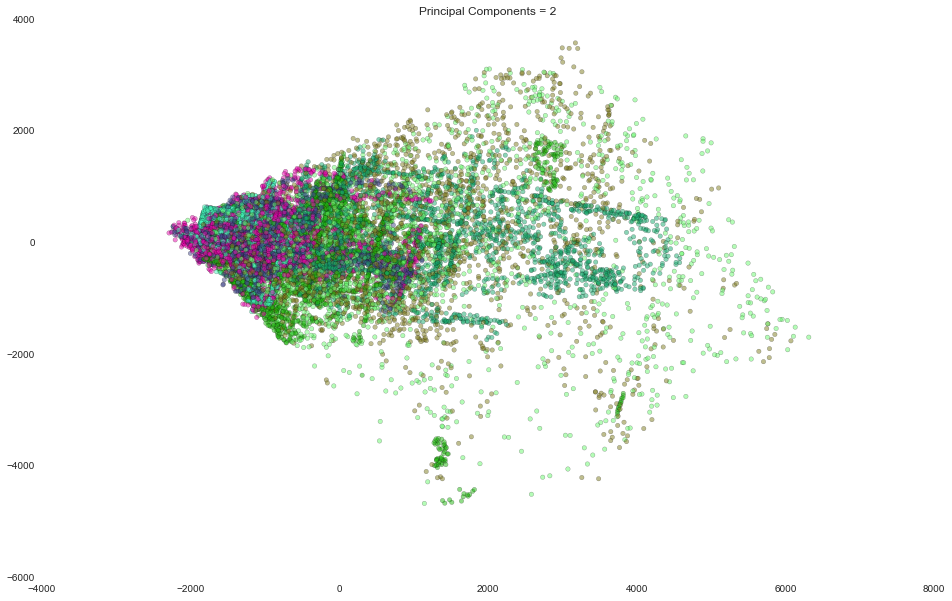

In [125]:
train_data.drop(['Tree', 'Cover_Type', 'Id'], axis=1, inplace=True)
test_data.drop('Id', axis=1, inplace=True)

pca = PCA(n_components=2)
transformed_data = pca.fit_transform(train_data)

colors = np.zeros((train_data_arr.shape[0], 3))
for i in range(colors.shape[0]):
    colors[i,] = random_colors[train_labels[i]-1]

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1)
dummy = ax.scatter(transformed_data[:,0], transformed_data[:,1], c=colors, alpha=0.5)
dummy = ax.set_title("Principal Components = 2")

###Section 3: Creating a Baseline Model for Kaggle

In [126]:
#Establish a baseline score in Kaggle using basic KNN model where K = 1
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_data.values, train_labels)
 
print 'With the oven preheated and our ingredients ready, pop it in the oven!' 
predictions = knn.predict(test_data.values).astype(int) 
print predictions.shape 
 
print "Just need to cut our delicious baked good into slices..." 
prediction_write = open("sampleSubmissionKNN1.csv", "wb") 
open_file_object = csv.writer(prediction_write) 
open_file_object.writerow(["Id","Cover_Type"]) 
open_file_object.writerows(zip(test_id, predictions)) 
prediction_write.close() 

With the oven preheated and our ingredients ready, pop it in the oven!
(565892,)
Just need to cut our delicious baked good into slices...


This baseline yields a Kaggle score of 0.71016 (leaderboard rank = 1175)

###Section 4: Run baseline models for comparison
To do this, we will need to create a development (validation) set out of the training data provided. This splitting will allow for us to test several classifiers at a high level before selecting the most insightful classifier for further definition.   

In [127]:
from sklearn.cross_validation import train_test_split

X = np.array(train_data)
Y = train_labels

shuffle = np.random.permutation(np.arange(X.shape[0]))
X,Y = X[shuffle],Y[shuffle]

train_subset_data, dev_data, train_subset_labels, dev_labels = train_test_split(X, Y, test_size=0.1, random_state=0)

In [128]:
#Baseline K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(train_subset_data, train_subset_labels)
print 'K-Nearest Neighbors yields an accuracy of %s' % (knn.score(dev_data, dev_labels)*100)

#Baseline Linear Regression
lr = LinearRegression() #initialize a logistic regression model
lr.fit(train_subset_data, train_subset_labels)
print '\nLinear Regression yields an accuracy of %s' % (lr.score(dev_data, dev_labels)*100)

#Baseline Logistic Regression
lm = LogisticRegression() #initialize a logistic regression model
lm.fit(train_subset_data, train_subset_labels)
print '\nLogistic Regression yields an accuracy of %s' % (lm.score(dev_data, dev_labels)*100)

#Baseline Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(train_subset_data, train_subset_labels)
print '\nGaussian Naive Bayes yields an accuracy of %s' % (gnb.score(dev_data, dev_labels)*100)

#Baseline Random Forest
rf = RandomForestClassifier()
rf.fit(train_subset_data, train_subset_labels)
print '\nRandom Forest yields an accuracy of %s' % (rf.score(dev_data, dev_labels)*100)

#Baseline "ExtraTrees"
et = ExtraTreesClassifier()
et.fit(train_subset_data, train_subset_labels)
print '\nExtra Trees yields an accuracy of %s' % (et.score(dev_data, dev_labels)*100)

K-Nearest Neighbors yields an accuracy of 80.9523809524

Linear Regression yields an accuracy of 40.8803405421

Logistic Regression yields an accuracy of 68.0555555556

Gaussian Naive Bayes yields an accuracy of 47.9497354497

Random Forest yields an accuracy of 82.8042328042

Extra Trees yields an accuracy of 83.7962962963


One surprise that pops out is the relative accuracy for KNN model (where K = 1) with respect to regressions and Naive Bayes. That said, both Random Forest and Extra Trees produce slightly superior results. 

With this initial validation complete, we will move forward with further developing a model based on the Extra Trees classifier.

In [129]:
#Establish a new baseline with Kaggle using the basic Extra Trees Classifier
et = ExtraTreesClassifier()
et.fit(train_data.values, train_labels)

predictions = et.predict(test_data.values).astype(int) 
print predictions.shape 
 
prediction_write = open("sampleSubmissionET1.csv", "wb") 
open_file_object = csv.writer(prediction_write) 
open_file_object.writerow(["Id","Cover_Type"]) 
open_file_object.writerows(zip(test_id, predictions)) 
prediction_write.close() 

(565892,)


This new baseline (using the Extra Trees classifier) yields a Kaggle score of 0.72416 (leaderboard rank = 1090)

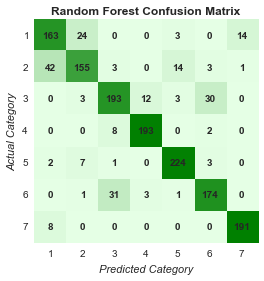

In [130]:
#See where the model is making errors
et.fit(train_subset_data, train_subset_labels)
predictions = et.predict(dev_data)
cf = confusion_matrix(dev_labels, predictions)
conf_arr = cf.tolist()
norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        if a == 0:
            tmp_arr.append(0)
        else:
            tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
cmap = sns.light_palette('green', as_cmap = True)
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=cmap, 
                interpolation='nearest')

width = len(conf_arr)
height = len(conf_arr[0])

for x in xrange(width):
    for y in xrange(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center',
                    weight='bold')
plt.title('Random Forest Confusion Matrix',weight='bold')
plt.ylabel('Actual Category', style='italic')
plt.xlabel('Predicted Category',style='italic')
items = [1,2,3,4,5,6,7]
plt.xticks(range(width), items)
plt.yticks(range(height), items)
plt.grid(b = None)

###Section 5: Feature Engineering and Parameter/Model Tuning

Parameter Tuning -- Attack the skew!

Something that we've seen in our error analysis throughout this exercise is that while the training data possesses an even split of observations between the seven cover_types, the test dataset possesses an overwhelming percentage of cover_types (1 and 2), over cover_type (3 thru 7). This was inferred by our relatively high Kaggle score and the distribution of our predictions. I.e. We predicted mostly 1 and 2 and received a score of ~70%.

To address this, we can attempt to de-skew the data by searching for target weights amongst the cover_types. By using a simple classifier (like KNN) and running for a few iterations in order to estimate feature weights across each run, we may be able to form a more generalizable expectation of cover_type distribution.

In [131]:
train_values = train_data.values
test_values = test_data.values

knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(train_values, train_labels)

#create a zero array to hold target weights
weights = np.zeros(7)

#iterate 5 times:
#extract a random subset of test data
#predict the KNN target value
#add the target weights to the weights array
for i in range(5):
    test_subset = test_values[np.random.choice(test_values.shape[0],10000)] #get a random 10000 example subset
    weights = weights + np.bincount(knn.predict(test_subset))[1:]
    
#create a target weights dictionary with the average predicted weights
weights = weights/5 #average weights
weight_dict = {i+1:weights[i]/np.sum(weights) for i in range(len(weights))} #dictionary of normalized average weights
print weights
print np.sum(weights)
print weight_dict

#With this code in place, we can add the attribute "class_weight=weight_dict" within our ExtraTreesClassifier

[ 3629.4  3864.4   723.     50.    647.6   431.4   654.2]
10000.0
{1: 0.36293999999999998, 2: 0.38644000000000001, 3: 0.072300000000000003, 4: 0.0050000000000000001, 5: 0.064759999999999998, 6: 0.043139999999999998, 7: 0.065420000000000006}


Feature Engineering - Sunlight/Energy received by a 30 by 30 patch 

The idea behind this feature is that different trees respond differently to amount of sunlight/energy.

The dataset provides values of Hillshade for every patch at 9 am, 12 noon and 3 pm. Hillshade is a measure of sunlight incident upon a patch. It has values between 0 and 255 where 0 represents absence of sunlight. Hillshade takes into account Sun's elevation, latitude, slope and aspect of the patch.

This engineered feature indicates the relative amount of sunlight/energy a patch receives. The assumption is that amount of sunlight is more directly correlated to Cover_Type than individual measures of Hillshade and hence is a better predictor. The amount of sunlight is calculated as Area under the curve of the below figure.

This figure below is a simplification of the curve because it is not a linear function. But despite the simplification we get an increase in accuracy.

To calculate the area, we measured time in seconds, which is shown below as 10,800 seconds (amount of seconds in a 3-hour period).

After calculating the energy feature, we drop the original hillshade features.

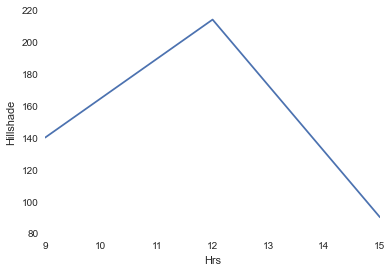

In [132]:
plt.figure() 

hillshade = [141, 215, 91]        # Hillshade values at 9 am, 12 noon and 3 pm
time = [9, 12, 15]                # Time at 9 am, 12 noon and 3 pm
plt.subplot(1, 1, 1)
plt.plot([9, 12, 15], [141, 215, 91])
x_l = plt.xlabel('Hrs')
y_l = plt.ylabel('Hillshade')


train_data['Energy'] = ((train_data['Hillshade_9am']+train_data['Hillshade_Noon'])/2)*10800 + ((train_data['Hillshade_Noon']+train_data['Hillshade_3pm'])/2)*10800
#train_data.drop('Hillshade_9am', axis=1, inplace=True)
#train_data.drop('Hillshade_Noon', axis=1, inplace=True)
#train_data.drop('Hillshade_3pm', axis=1, inplace=True)

Feature Engineering/Preprocessing - Scrubbing the Hillshade_3pm values of 0

In plotting the Hillshade values against one another, we see that "Hillshade_3pm" actually includes a group of zeroes in the dataset. As this is not the case with either of the other Hillshade features, we may find that this batch of zeroes can skew our data unknowingly.

To address this concern, let's fill in the zero-value observations for Hillshade_3pm with the overall median of the non-zero Hillshade_3pm values.

In [134]:
from sklearn.preprocessing import Imputer

temp = train_data.copy()
cols = temp.columns.tolist()
cols = cols[:8]+ cols[9:] + [cols[8]]
temp = temp[cols]

X, y, X_train_data_missing, y_train_data_missing = temp[temp.Hillshade_3pm!=0].values[:,:-1],temp[temp.Hillshade_3pm!=0].values[:,-1:].ravel(),temp[temp.Hillshade_3pm==0].values[:,:-1],temp[temp.Hillshade_3pm==0].values[:,-1:].ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y)
imp = Imputer(missing_values='NaN', strategy='median', axis=1)
imp.fit(X_train,y_train)
temp.Hillshade_3pm.loc[temp.Hillshade_3pm==0]=imp.transform(X_train_data_missing)
train_data.Hillshade_3pm=temp.Hillshade_3pm


temp=test_data.copy()
cols=temp.columns.tolist()
cols=cols[:8] + cols[9:] + [cols[8]]
temp=temp[cols]


X_test_data_missing = temp[temp.Hillshade_3pm==0].values[:,:-1]
temp.Hillshade_3pm.loc[temp.Hillshade_3pm==0] = imp.transform(X_test_data_missing)
test_data.Hillshade_3pm = temp.Hillshade_3pm

Feature Engineering - Is patch closer to Roadway and Firepoint than water 

The idea behind these features is that hydrology affect on trees wil be impacted if human effects (Roadways) and natural hazards (fires) are nearby.
These features indicate if roadways and fire points are closer to a patch than hydrology.
These features have improved accuracy

In [ ]:
data['Is_Roadway_Closer_than_Water'] = (data['Horizontal_Distance_To_Roadways'] < data['Horizontal_Distance_To_Hydrology'])
data['Is_Firepoint_Closer_than_Water'] = (data['Horizontal_Distance_To_Fire_Points'] < data['Horizontal_Distance_To_Hydrology'])

Feature Engineering - Creating features to differentiate Cover_Types 1 and 2 

The test data is unusual because it is heavily skewed towards Cover_Types 1 and 2. Additionally, train data shows that these two cover types are very similar.
Nate's bivariate distribution contour plot will demonstrate this point 
To induce variation in the data we have added two extra features by multiplying features together. Multiplication will amplify the variation.
These features have increased the accuracy

In [ ]:
data['ShdHvdH'] = data['Slope'] * data['Horizontal_Distance_To_Hydrology'] * data['Vertical_Distance_To_Hydrology']
data['hdFPhdR'] = data['Horizontal_Distance_To_Fire_Points'] * data['Horizontal_Distance_To_Roadways'] 

Feature Engineering - Grouping like-terms for Soil Types

In plotting the 40 different soil types above (Data Exploration section), we saw that each type of tree is only represented in a handful of soil types. That is, only a portion of the soil types suit one type of tree versus another. In digging deeper (https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info), we find that the soil type (which is a four-digit ID) can be split into two sections. One section is an arbitrary ID code to aid the original data gatherers. The first two digits, though, represents a specific grouping of tree types based on the soil. 

With this in mind, we can map the original 40 soil types to actual 11 types.

In [135]:
def convert_soil_types(fr):
    new_soil_1 = np.zeros(fr.shape[0])
    new_soil_2 = np.zeros(fr.shape[0])
    new_soil_3 = np.zeros(fr.shape[0])
    new_soil_4 = np.zeros(fr.shape[0])
    new_soil_5 = np.zeros(fr.shape[0])
    new_soil_6 = np.zeros(fr.shape[0])
    new_soil_7 = np.zeros(fr.shape[0])
    new_soil_8 = np.zeros(fr.shape[0])
    new_soil_9 = np.zeros(fr.shape[0])
    new_soil_10 = np.zeros(fr.shape[0])
    new_soil_11 = np.zeros(fr.shape[0])

    new_soil_1 = np.where(fr['Soil_Type1']==1, 1, new_soil_1)
    new_soil_1 = np.where(fr['Soil_Type2']==1, 1, new_soil_1)
    new_soil_1 = np.where(fr['Soil_Type3']==1, 1, new_soil_1)
    new_soil_1 = np.where(fr['Soil_Type4']==1, 1, new_soil_1)
    new_soil_1 = np.where(fr['Soil_Type5']==1, 1, new_soil_1)
    new_soil_1 = np.where(fr['Soil_Type6']==1, 1, new_soil_1)

    new_soil_2 = np.where(fr['Soil_Type7']==1, 1, new_soil_2)
    new_soil_2 = np.where(fr['Soil_Type8']==1, 1, new_soil_2)

    new_soil_3 = np.where(fr['Soil_Type9']==1, 1, new_soil_3)

    new_soil_4 = np.where(fr['Soil_Type10']==1, 1, new_soil_4)
    new_soil_4 = np.where(fr['Soil_Type11']==1, 1, new_soil_4)
    new_soil_4 = np.where(fr['Soil_Type12']==1, 1, new_soil_4)
    new_soil_4 = np.where(fr['Soil_Type13']==1, 1, new_soil_4)

    new_soil_5 = np.where(fr['Soil_Type14']==1, 1, new_soil_5)
    new_soil_5 = np.where(fr['Soil_Type15']==1, 1, new_soil_5)

    new_soil_6 = np.where(fr['Soil_Type16']==1, 1, new_soil_6)
    new_soil_6 = np.where(fr['Soil_Type17']==1, 1, new_soil_6)

    new_soil_7 = np.where(fr['Soil_Type18']==1, 1, new_soil_7)

    new_soil_8 = np.where(fr['Soil_Type19']==1, 1, new_soil_8)
    new_soil_8 = np.where(fr['Soil_Type20']==1, 1, new_soil_8)
    new_soil_8 = np.where(fr['Soil_Type21']==1, 1, new_soil_8)

    new_soil_9 = np.where(fr['Soil_Type22']==1, 1, new_soil_9)
    new_soil_9 = np.where(fr['Soil_Type23']==1, 1, new_soil_9)

    new_soil_10 = np.where(fr['Soil_Type24']==1, 1, new_soil_10)
    new_soil_10 = np.where(fr['Soil_Type25']==1, 1, new_soil_10)
    new_soil_10 = np.where(fr['Soil_Type26']==1, 1, new_soil_10)
    new_soil_10 = np.where(fr['Soil_Type27']==1, 1, new_soil_10)
    new_soil_10 = np.where(fr['Soil_Type28']==1, 1, new_soil_10)
    new_soil_10 = np.where(fr['Soil_Type29']==1, 1, new_soil_10)
    new_soil_10 = np.where(fr['Soil_Type30']==1, 1, new_soil_10)
    new_soil_10 = np.where(fr['Soil_Type31']==1, 1, new_soil_10)
    new_soil_10 = np.where(fr['Soil_Type32']==1, 1, new_soil_10)
    new_soil_10 = np.where(fr['Soil_Type33']==1, 1, new_soil_10)
    new_soil_10 = np.where(fr['Soil_Type34']==1, 1, new_soil_10)

    new_soil_11 = np.where(fr['Soil_Type35']==1, 1, new_soil_11)
    new_soil_11 = np.where(fr['Soil_Type36']==1, 1, new_soil_11)
    new_soil_11 = np.where(fr['Soil_Type37']==1, 1, new_soil_11)
    new_soil_11 = np.where(fr['Soil_Type38']==1, 1, new_soil_11)
    new_soil_11 = np.where(fr['Soil_Type39']==1, 1, new_soil_11)
    new_soil_11 = np.where(fr['Soil_Type40']==1, 1, new_soil_11)

    fr['new_soil_1'] = new_soil_1
    fr['new_soil_2'] = new_soil_2
    fr['new_soil_3'] = new_soil_3
    fr['new_soil_4'] = new_soil_4
    fr['new_soil_5'] = new_soil_5
    fr['new_soil_6'] = new_soil_6
    fr['new_soil_7'] = new_soil_7
    fr['new_soil_8'] = new_soil_8
    fr['new_soil_9'] = new_soil_9
    fr['new_soil_10'] = new_soil_10
    fr['new_soil_11'] = new_soil_11

    return fr


In [136]:
#Azimuth Adjustment
def adjust(x): 
    if x+180>360: 
        return x-180 
    else: 
        return x+180 

In [137]:
def feature_engineering(data_to_tranform):

    data = data_to_tranform.copy()
    
    data = convert_soil_types(data)

    data['Aspect2'] = data.Aspect.map(adjust) 

    data['Energy'] = ((data['Hillshade_9am']+data['Hillshade_Noon'])/2)*10800 + ((data['Hillshade_Noon']+data['Hillshade_3pm'])/2)*10800
    data.drop('Hillshade_9am', axis=1, inplace=True)
    data.drop('Hillshade_Noon', axis=1, inplace=True)
    data.drop('Hillshade_3pm', axis=1, inplace=True)

    data['Above_Sea_Level'] = data.Vertical_Distance_To_Hydrology < 0 
    data['Vertical_To_Water'] = data.Elevation-data.Vertical_Distance_To_Hydrology 
    data['Horizontal_To_Water'] = data.Elevation-data.Horizontal_Distance_To_Hydrology*0.2 
    data['Pythagorean_To_Water'] = (data['Horizontal_Distance_To_Hydrology']**2+data['Vertical_Distance_To_Hydrology']**2)**0.5 
    data['Water_And_Fire'] = data['Horizontal_Distance_To_Hydrology']+data['Horizontal_Distance_To_Fire_Points'] 
    data['Water_Less_Fire'] = (data['Horizontal_Distance_To_Hydrology']-data['Horizontal_Distance_To_Fire_Points']) 
    data['Water_And_Roadway'] = (data['Horizontal_Distance_To_Hydrology']+data['Horizontal_Distance_To_Roadways']) 
    data['Water_Less_Roadway'] = (data['Horizontal_Distance_To_Hydrology']-data['Horizontal_Distance_To_Roadways']) 
    data['Fire_And_Roadway'] = (data['Horizontal_Distance_To_Fire_Points']+data['Horizontal_Distance_To_Roadways']) 
    data['Fire_Less_Roadway'] = (data['Horizontal_Distance_To_Fire_Points']-data['Horizontal_Distance_To_Roadways']) 
    data['Is_Roadway_Closer_than_Water'] = (data['Horizontal_Distance_To_Roadways'] < data['Horizontal_Distance_To_Hydrology'])
    data['Is_Firepoint_Closer_than_Water'] = (data['Horizontal_Distance_To_Fire_Points'] < data['Horizontal_Distance_To_Hydrology'])
    
    #Feature Engineering - Product-based features
    data['Extra_1'] = data['Slope'] * data['Horizontal_Distance_To_Hydrology'] * data['Vertical_Distance_To_Hydrology']
    data['Extra_2'] = data['Horizontal_Distance_To_Fire_Points'] * data['Horizontal_Distance_To_Roadways'] 
    return data

In [139]:
#Let's run the basic ExtraTrees model (un-optimized, as we have not run a grid search yet) using the previously established features and parameter tuning:

train_data_engd = feature_engineering(train_data)
test_data_engd = feature_engineering(test_data)

clf = ExtraTreesClassifier(class_weight = weight_dict)
clf = clf.fit(train_data_engd.values, train_labels)
predictions = clf.predict(test_data_engd.values).astype(int)
print predictions.shape

predictions_write = open("sampleSubmissionFE1.csv", "wb") 
open_file_object = csv.writer(predictions_write) 
open_file_object.writerow(["Id","Cover_Type"]) 
open_file_object.writerows(zip(test_id, predictions)) 
prediction_write.close() 
print("File created!")

#print "Confusion matrix:\n%s" % confusion_matrix(test_labels, predictions)

(565892,)
File created!


In [140]:
#With this result, what would happen if we attempted to aid the ExtraTrees classifier with an AdaBoost classifier being applied on its result? 
clf1 = ExtraTreesClassifier(class_weight = weight_dict)
clf = AdaBoostClassifier(clf1)
clf = clf.fit(train_data_engd.values, train_labels)
predictions = clf.predict(test_data_engd.values).astype(int)
print predictions.shape

predictions_write = open("sampleSubmissionFE2.csv", "wb") 
open_file_object = csv.writer(predictions_write) 
open_file_object.writerow(["Id","Cover_Type"]) 
open_file_object.writerows(zip(test_id, predictions)) 
prediction_write.close()
print("File created!")

#print "Confusion matrix:\n%s" % confusion_matrix(test_labels, predictions) 

(565892,)
File created!


In [142]:
#Now, let's optimize our model using a RandomizedSearchCV, searching for the best parameters with which to test our model.
train_matrix = train_data_engd.as_matrix() 
test_X = test_data_engd.as_matrix() 
n_features = int(train_matrix.shape[1]) 

clf = ExtraTreesClassifier()   
clf = clf.fit(train_matrix, train_labels) 
param_grid = { 
    "n_estimators" : sp_randint(10, 1000), 
    "max_features": sp_randint(0,20), 
    "min_samples_leaf": sp_randint(1,10), 
    "min_samples_split": sp_randint(1,10), 
    "bootstrap": ["True", "False"],
    "criterion": ["gini", "entropy"], 
} 

grid_search = RandomizedSearchCV(clf, n_iter=10, param_distributions=param_grid) 
grid_search.fit(train_matrix, train_labels) 
best_parameters = grid_search.best_params_ 

print best_parameters 

clfa = ExtraTreesClassifier(best_parameters, class_weight = weight_dict) 

clf = AdaBoostClassifier(clfa) 
 
clf.fit(train_matrix, train_labels)
 
predictions = clf.predict(test_data_engd.values).astype(int) 
print predictions.shape 

prediction_write = open("sampleSubmissionGSCV_Ada1.csv", "wb") 
open_file_object = csv.writer(prediction_write) 
open_file_object.writerow(["Id","Cover_Type"]) 
open_file_object.writerows(zip(test_id, predictions)) 
prediction_write.close() 
print("File created!")

{'bootstrap': 'False', 'min_samples_leaf': 1, 'n_estimators': 17, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 19}


TypeError: unsupported operand type(s) for -: 'dict' and 'int'

At this point, we are still seeing the largest error rate in misclassifications of cover_types 1 and 2. What if we targeted and split out the observations that are falling into cover types 1 and 2, constructing a model and running simply on that subset? Would that help in our dealings with the more common errors?

Handling Cover_Types 1 and 2 separately - Implementation of Nate's idea 

Here we are retraining the same classifier with the same set of engineered features but only on train data subset on Cover_Types 1 and 2. The idea is to use this classifier to predict Cover_Types only for those test data observations, which were predicted as Cover_Types 1 and 2 by the Global classifier.

This did not improve the accuracy but we are mentioning this here because we think it is interesting.

As the subset classifier is wrapped in a function below (subset_classifier()), so different types of classifiers can be plugged in and tested as well.

In [147]:
# Processing Cover_Type 1 and 2 via separate classifier trained only on Cover_type 1 and 2
# Then update global predictions with the subset predictions

# Reading data from filesystem
train_data = pd.read_csv('train.csv', header=0)
test_data = pd.read_csv('test.csv', header=0) 

# Subset of train_data for Cover_Types 1 and 2
cover_type_1 = train_data[train_data['Cover_Type']==1]
cover_type_2 = train_data[train_data['Cover_Type']==2] 
cover_type_1_and_2 = pd.concat([cover_type_1, cover_type_2], ignore_index=True)
train_labels_subset = cover_type_1_and_2['Cover_Type'].as_matrix() 
cover_type_1_and_2.drop(['Cover_Type', 'Id'], axis=1, inplace=True)

# Subset of test data
# Index of predictions with Cover_Type==1 
predicted_1 = np.where(predictions == 1)[0]
# Index of predictions with Cover_Type==2  
predicted_2 = np.where(predictions == 2)[0]
predicted_1_or_2 = np.hstack((predicted_1, predicted_2))
test_data_subset = test_data.ix[predicted_1_or_2]
test_data_subset.drop(['Id'], axis=1, inplace=True) 

# Applying feature engineering to train subset
train_tranformed_subset = feature_engineering(cover_type_1_and_2)
train_matrix_subset = train_tranformed_subset.as_matrix()

# Applying feature engineering to test subset
test_transformed = feature_engineering(test_data_subset)
test_X_subset = test_transformed.as_matrix() 

# Creating function to classify subset
def subset_classifier(train_data, train_labels, test_data):
    etc_subset = ExtraTreesClassifier(n_estimators = 600, max_features = 0.3, class_weight = weight_dict)
    adbc_subset = AdaBoostClassifier(etc_subset) 
    adbc_subset.fit(train_data, train_labels)
    predictions_subset = adbc_subset.predict(test_data).astype(int)
    return predictions_subset

predictions_subset = subset_classifier(train_matrix_subset, train_labels_subset, test_X_subset)

# Over writing global predictions with subset predictions
# Global predictions is in variable 'predictions'
with open('sampleSubmissionFE3.csv', "wt") as outfile:
    outfile.write("Id,Cover_Type\n")
    for i, val in enumerate(predicted_1_or_2):
        predictions[val] = predictions_subset[i]
        outfile.write("%s,%s\n"%(test_ids[e], val))

IndexError: index out of bounds

###Section 6: Results Summary and Reflection

As we saw above, our "best" model achieved an accuracy score of ###### on Kaggle, which would fall into the ##### rank on the leaderboard (had the competition still been active).
Looking back at our incremental results and relative improvement (by Kaggle score achieved), we show the following:

Default/Baseline KNN model: Accuracy = ######, Rank = ######
Default/Baseline ExtraTrees model: Accuracy = ######, Rank = ######
ExtraTrees model with feature engineering and tuning: Accuracy = ######, Rank = ######
ExtraTrees model with AdaBoost added into an ensemble with feature engineering and tuning: Accuracy = ######, Rank = ######
ExtraTrees model with AdaBoost added into an ensemble with feature engineering, tuning, and optimal parameters: Accuracy = ######, Rank = ######

At the end of the day, the team improve our accuracy against the test set by ###### accuracy points (rank improvement of #### places).

While the team had considered adding more calculated features in order to discover relationships underlying the dataset, we ultimately settled on the final model as it would have potentially created concern for overfitting our model. at the end of the day, the team improve our accuracy against the test set by ###### accuracy points (rank improvement of #### places). Also, had time permitted, we would have liked to dive deeper into the skewed nature of the test set cover types, in comparison to the even spread of cover types in the training set.

In [ ]:
##Reference Material
#Current code for top Kaggle score

import os
import csv
import sys 
import numpy as np 
import pandas as pd 
from math import sqrt
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 
from sklearn.grid_search import RandomizedSearchCV 
from sklearn.metrics import confusion_matrix 
from sklearn import preprocessing 
from scipy.stats import randint as sp_randint
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.ensemble import AdaBoostClassifier 

path = '/Users/jaredmaslin/Desktop/kaggle_forest_cover/' 

from time import time 
t0 = time() 

print "Let's grab for our ingredients to start making a delicious dish!" 

train_data = pd.read_csv(os.path.join(path,'train.csv'), header=0) 
train_labels = train_data['Cover_Type'].as_matrix() 
train_id = train_data['Id'].as_matrix() 
train_data.drop(['Cover_Type', 'Id'], axis=1, inplace=True) 
test_data = pd.read_csv(os.path.join(path,'test.csv'), header=0) 
test_id = test_data['Id'].as_matrix() 
test_data.drop(['Id'], axis=1, inplace=True)  


print "Now, let's use some of our ingredients to create a wonderful mix!" 

#Azimuth Adjustment
def adjust(x): 
    if x+180>360: 
        return x-180 
    else: 
        return x+180 

#Feature Engineering
train_data['Aspect2'] = train_data.Aspect.map(adjust) 
test_data['Aspect2'] = test_data.Aspect.map(adjust) 

train_data['Energy'] = ((train_data['Hillshade_9am']+train_data['Hillshade_Noon'])/2)*10800 + ((train_data['Hillshade_Noon']+train_data['Hillshade_3pm'])/2)*10800
test_data['Energy'] = ((test_data['Hillshade_9am']+test_data['Hillshade_Noon'])/2)*10800 + ((test_data['Hillshade_Noon']+test_data['Hillshade_3pm'])/2)*10800

train_data.drop('Hillshade_9am', axis=1, inplace=True)
test_data.drop('Hillshade_9am', axis=1, inplace=True)

train_data.drop('Hillshade_Noon', axis=1, inplace=True)
test_data.drop('Hillshade_Noon', axis=1, inplace=True)

train_data.drop('Hillshade_3pm', axis=1, inplace=True)
test_data.drop('Hillshade_3pm', axis=1, inplace=True)

train_data['Above_Sea_Level'] = train_data.Vertical_Distance_To_Hydrology < 0 
test_data['Above_Sea_Level'] = test_data.Vertical_Distance_To_Hydrology < 0 

train_data['Vertical_To_Water'] = train_data.Elevation-train_data.Vertical_Distance_To_Hydrology 
test_data['Vertical_To_Water'] = test_data.Elevation-test_data.Vertical_Distance_To_Hydrology 

train_data['Horizontal_To_Water'] = train_data.Elevation-train_data.Horizontal_Distance_To_Hydrology*0.2 
test_data['Horizontal_To_Water'] = test_data.Elevation-test_data.Horizontal_Distance_To_Hydrology*0.2 
      
train_data['Pythagorean_To_Water'] = (train_data['Horizontal_Distance_To_Hydrology']**2+train_data['Vertical_Distance_To_Hydrology']**2)**0.5 
test_data['Pythagorean_To_Water'] = (test_data['Horizontal_Distance_To_Hydrology']**2+test_data['Vertical_Distance_To_Hydrology']**2)**0.5 

train_data['Water_And_Fire'] = train_data['Horizontal_Distance_To_Hydrology']+train_data['Horizontal_Distance_To_Fire_Points'] 
test_data['Water_And_Fire'] = test_data['Horizontal_Distance_To_Hydrology']+test_data['Horizontal_Distance_To_Fire_Points'] 
 
train_data['Water_Less_Fire'] = abs(train_data['Horizontal_Distance_To_Hydrology']-train_data['Horizontal_Distance_To_Fire_Points']) 
test_data['Water_Less_Fire'] = abs(test_data['Horizontal_Distance_To_Hydrology']-test_data['Horizontal_Distance_To_Fire_Points']) 

train_data['Water_And_Roadway'] = abs(train_data['Horizontal_Distance_To_Hydrology']+train_data['Horizontal_Distance_To_Roadways']) 
test_data['Water_And_Roadway'] = abs(test_data['Horizontal_Distance_To_Hydrology']+test_data['Horizontal_Distance_To_Roadways']) 
 
train_data['Water_Less_Roadway'] = abs(train_data['Horizontal_Distance_To_Hydrology']-train_data['Horizontal_Distance_To_Roadways']) 
test_data['Water_Less_Roadway'] = abs(test_data['Horizontal_Distance_To_Hydrology']-test_data['Horizontal_Distance_To_Roadways']) 
 
train_data['Fire_And_Roadway'] = abs(train_data['Horizontal_Distance_To_Fire_Points']+train_data['Horizontal_Distance_To_Roadways']) 
test_data['Fire_And_Roadway'] = abs(test_data['Horizontal_Distance_To_Fire_Points']+test_data['Horizontal_Distance_To_Roadways']) 

train_data['Fire_Less_Roadway'] = abs(train_data['Horizontal_Distance_To_Fire_Points']-train_data['Horizontal_Distance_To_Roadways']) 
test_data['Fire_Less_Roadway'] = abs(test_data['Horizontal_Distance_To_Fire_Points']-test_data['Horizontal_Distance_To_Roadways']) 

train_data['Is_Roadway_Closer_than_Water'] = (train_data['Horizontal_Distance_To_Roadways'] < train_data['Horizontal_Distance_To_Hydrology'])
test_data['Is_Roadway_Closer_than_Water'] = (test_data['Horizontal_Distance_To_Roadways'] < test_data['Horizontal_Distance_To_Hydrology'])

train_data['Is_Firepoint_Closer_than_Water'] = (train_data['Horizontal_Distance_To_Fire_Points'] < train_data['Horizontal_Distance_To_Hydrology'])
test_data['Is_Firepoint_Closer_than_Water'] = (test_data['Horizontal_Distance_To_Fire_Points'] < test_data['Horizontal_Distance_To_Hydrology'])

train_matrix = train_data.as_matrix() 
test_X = test_data.as_matrix() 
n_features = int(sqrt(train_matrix.shape[1])) 
 
print "With our best magnifying glass, lets find the right combination of ingredients and get ready to bake!"  

#clf = ExtraTreesClassifier()   
#clf = clf.fit(train_matrix, train_labels) 
#param_grid = { 
    #"n_estimators" : sp_randint(10, 1000), 
    #"max_features": sp_randint(0,20), 
    #"min_samples_leaf": sp_randint(1,10), 
    #"min_samples_split": sp_randint(1,10), 
    #"criterion": ["gini", "entropy"], 
#} 

#grid_search = RandomizedSearchCV(clf, n_iter=20, param_distributions=param_grid) 
#grid_search.fit(train_matrix, train_labels) 
#best_parameters = grid_search.best_params_ 

#the following parameters are good  
#best_parameters = {'n_estimators' : 35, 'max_features' : 17, 'min_samples_split' : 3, \ 
#'min_samples_leaf' : 3, 'bootstrap' : False, 'criterion': "entropy"} 

#print best_parameters 

#clfa = ExtraTreesClassifier(n_estimators = 858, max_features = 7, min_samples_leaf = 1, min_samples_split = 2, criterion = 'entropy') 
clfa = ExtraTreesClassifier(n_estimators = 600, max_features = 0.3)

clf = AdaBoostClassifier(clfa, n_estimators = 600) 
 
clf = clf.fit(train_matrix, train_labels)
 
print 'With the oven preheated and our ingredients ready, pop it in the oven!'
 
predictions = clf.predict(test_X).astype(int) 
print predictions.shape 
 
print "Just need to cut our delicious baked good into slices..." 

prediction_write = open(os.path.join(path,"sampleSubmissionGSCV_New1.csv"), "wb") 
open_file_object = csv.writer(prediction_write) 
open_file_object.writerow(["Id","Cover_Type"]) 
open_file_object.writerows(zip(test_id, predictions)) 
prediction_write.close() 
print 'Ready to eat! (Be very careful! Contents hot!)'  

print 'Wait... how long did that take?'

print("... in %0.3fs" % (time() - t0))